# Problem Statement
- A firm ABC Consultancy services offers various consultancy services. As part of marketing strategy, the firm wants to 
    - build a model that reads the posts of category - 'Anger' and 'Meditation' from reddit
    - able to classify the category to whichg the post belongs
    - Using the prediction can offer Anger Management or Meditaion Session services as part of marketing/ consultancy services
    - For this we need to build and train the model so that model can correctly classify the posts and enable the firm to run business model

## Approach Used
- Webscrape reddit to collect posts for category - Anger, Meditation
- Make a dataset of combined posts
- Label categories as 
    - Anger - 1
    - Meditation - 0
- From this dataset, randomly select 100 posts which will be used to test predictions on various model that will be used for modeling
- Save (on the disk as csv files) the big dataset for train/test purpose during modeling and sliced dataset as final test on model
- Read both dataset on do cleaning
    - do train/test split
    - consider only words by using regex
    - lower case the characters in posts
    - apply lemmatization
    - clean the posts
- Use CountVectorizer using stopwords(including 'Anger' and 'Meditation' and synonym words to these categories) to remove these words from features
    - get the features list
    - do this for train,test, final test datas set
- Train model on the vectorizer 
- For predictions
    - check for train/test score, final test score
    - accuracy of validation set and final test set
- Compare and recommend the best model based on comparison


## Please note that this notebook is only to
- read two csv files from dataset folder
    - 1st file to train model
    - 2nd file to do final test of trained model
- make a wordcloud of all posts by using 'Anger' and 'Meditation' and synonyms of 2 categories in stop words
    - this is to see which words will be occuring most frequently
- Please install textblob using pip install -U textblob

## Readme
Read more [here](./Readme.md)

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import json
import seaborn as sns
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from os import path
from PIL import Image
import os

from wordcloud import WordCloud, STOPWORDS


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import re


from bs4 import BeautifulSoup
#from nltk.corpus import stopwords

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

import warnings
warnings.simplefilter(action='ignore')

## Common Function definition section

In [2]:
def lemmatize_words(posts):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in posts]
    lemmatized_words = list(set(lemmatized_words))
    return (lemmatized_words)

#### Steps of function  - remove html code artefacts, remove non-letters, convert into lowercase,  remove stop words

In [3]:
def review_to_words(raw_posts):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    posts_text = BeautifulSoup(raw_posts).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", posts_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Lemmatize the words
    words = lemmatize_words(words)
   
    
    # 5. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(STOPWORDS) ## STopwords of wordcloud
    #set(stopwords.words('english'))
    
    # 6. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

### Below is the function to get the top n words

In [4]:
def get_top_n_words(corpus,stop_words,n=None):
#     vec = CountVectorizer(stop_words = 'english').fit(corpus)
#     bag_of_words = vec.transform(corpus)
    vec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,#lemmatize_words,#None,
                             stop_words = stop_words,#None,
                             max_features = 2500,
                            max_df=0.9,
                            min_df=3,
                         ngram_range=(1,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Below is the function to generate WordCloud from cleaned posts

In [5]:
def generate_word_cloud(df,n):
    text = ' '
    common_words = get_top_n_words(df['posts'],stop_words,n)
    for word, freq in common_words:
        text = text + word + ' '


    wc = WordCloud(max_words= 100,
                          width = 744, 
                          height = 544,
                          background_color ='white',
                          #stopwords=stop_words, 
                          contour_width=3, 
                          contour_color='steelblue',
                          min_font_size = 10).generate(text) 
    return wc

### Initialize a dataframe and use this dataframe to store the final scores of various model
- This dataframe can be used as final comparison model for all type of classifiers used during modeling

In [6]:
model_matrix_df = pd.DataFrame(columns=['model_type','train_score','test_score','val_accrcy',
                                        'final_test_accrcy','final_test_specificity','final_test_sensitivity',
                                        'total_test_posts','fale_postive','fale_negative'],
                               index=['model_type'])

### Below is the function to fit model to do final predictions using classifier passed in model parameter

In [7]:
final_predictions_df=pd.DataFrame()

In [8]:
def model_fit(train_data_features,y_train,test_data_features,y_test,X_TEST_data_features,model,model_name):
    
    
    model.fit(train_data_features,y_train)
    training_score = model.score(train_data_features,y_train)
    test_score = model.score(test_data_features,y_test)
    
    print('training score {0}: '.format(training_score))
    print('test score {0}: '.format(test_score))
    
    predictions = model.predict(test_data_features)
    print('--------')
    print('Confusion Matrix')
    print(confusion_matrix(y_test, predictions))
    tn, fp, fn, tp = confusion_matrix(y_test,
                              predictions).ravel()
    print('True Negative: {0}'.format(tn))
    print('False Positive: {0}'.format(fp))
    print('False Negative: {0}'.format(fn))
    print('True Positive: {0}'.format(tp))
    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens, 4)}')
    # Calculate specificity.
    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec, 4)}')
    print('--------')    

    reddit_category = ['Meditation','Anger'] # As set 1 - 'Anger' , 0 - 'Meditation'
    X_TEST_PREDICT = model.predict(X_TEST_data_features.toarray())
    
    X_TEST_List = list(to_predict_df['target'])
    ## make dataframe for comparison between predictions and actual observations for target variable
    predicted_df = pd.DataFrame(zip(X_TEST_PREDICT,X_TEST_List),
                                columns=['predicted_target','actual_target'])
    
    
    
    ## rowIds where predicted value is not same as actual value
    row_ids = predicted_df[predicted_df['predicted_target'] != predicted_df['actual_target']].index
    
    str1 = 'Comparison between predicted and actual target values on the sliced dataset from Original TestSet of posts'
    print(str1.upper())

    print('No. of unmatched predictions wrt actual values: {0}'.format(len(list(row_ids))))
    print('-----------')
    print('Row index where Predicted Target Value is not same as Actual Target Value')
    
#     list_index = []
#     for id1 in row_ids:
#         list_index.append(id1)
    print(list(row_ids))
    
    #print(to_predict_df[[list_index]])
    #print(predicted_df.loc[[list(row_ids)]].to_string())
    
    print('--------')
    print('Confusion Matrix for predictions on sliced Test data Set')
    print(confusion_matrix(to_predict_df['target'], X_TEST_PREDICT))
    tn, fp, fn, tp = confusion_matrix(to_predict_df['target'],
                              X_TEST_PREDICT).ravel()
    print('True Negative: {0}'.format(tn))
    print('False Positive: {0}'.format(fp))
    print('False Negative: {0}'.format(fn))
    print('True Positive: {0}'.format(tp))
    final_sens = tp / (tp + fn)
    print(f'Sensitivity: {round(final_sens, 4)}')
    # Calculate specificity.
    final_spec = tn / (tn + fp)
    print(f'Specificity: {round(final_spec, 4)}')
    print('--------')
    
    validation_accuracy = accuracy_score(y_test, predictions)
    final_test_accuracy = accuracy_score(to_predict_df['target'], X_TEST_PREDICT)
    
    print('Accuracy of Model on validation data set: %.2f'%(validation_accuracy))
    print('Accuracy of Model on sliced Test Data Set: {0}'.
          format(final_test_accuracy))
    
    pred_proba = [i[1] for i in model.predict_proba(X_TEST_data_features.toarray())]

    pred_df = pd.DataFrame({'true_values': to_predict_df['target'],
                            'pred_probs':pred_proba})
    pred_df
    
    ####### set the scores in the metrics dataframe
    model_matrix_df.loc[model_name,'model_type'] = model_name
    model_matrix_df.loc[model_name,'train_score'] = training_score
    model_matrix_df.loc[model_name,'test_score'] = test_score
    model_matrix_df.loc[model_name,'val_accrcy'] = validation_accuracy
    model_matrix_df.loc[model_name,'final_test_accrcy'] = final_test_accuracy
    model_matrix_df.loc[model_name,'final_test_specificity'] = final_spec
    model_matrix_df.loc[model_name,'final_test_sensitivity'] = final_sens
    model_matrix_df.loc[model_name,'total_test_posts'] = 100
    model_matrix_df.loc[model_name,'fale_postive'] = fp
    model_matrix_df.loc[model_name,'fale_negative'] = fn
   
    ##return probability of final test predictions
    return pred_df

### Below is the fucntion to check on model type and using best parameter initiate the correct model and call above defined function to fit the model 
- After finding best param, call the model_fit function to fit the model and do predictions

In [9]:
def common_fittingmodel(train_data_features,y_train,test_data_features,y_test,X_TEST_data_features,model_type):
    
    #### If model type is Lasso ##############
    if model_type == 'Lasso':
        pipe = Pipeline([
            ('lr',LogisticRegression())
        ])

        pipe_params = {
            'lr__penalty': ['l1'], #lasso
            'lr__C': [1, 1.5, 2, 2.5],
            'lr__class_weight': ['balanced'],
            'lr__warm_start': [True, False],
            'lr__random_state': [42],
            'lr__solver': ['liblinear']
        }
        
        gsv = GridSearchCV(pipe,param_grid=pipe_params,cv=5)
        gsv.fit(train_data_features,y_train)

        best_param_dict = gsv.best_params_
        print(f'Best params = {best_param_dict}')

        model = LogisticRegression(penalty=best_param_dict['lr__penalty'],
                                   C=best_param_dict['lr__C'],
                                    class_weight=best_param_dict['lr__class_weight'],
                                     warm_start=best_param_dict['lr__warm_start'],
                                     random_state=best_param_dict['lr__warm_start'],
                                     solver=best_param_dict['lr__solver'])
       
        # call the function to fit grid serach and do prediction etc
        pred_df = model_fit(train_data_features,y_train,test_data_features,
                            y_test,X_TEST_data_features,model,'Lasso')
      
    ############# If model type is ridge ##############
    elif model_type == 'Ridge':
        pipe = Pipeline([
            ('lr',LogisticRegression())
        ])

        pipe_params = {
            'lr__penalty': ['l2'], #ridge
            'lr__C': [1, 1.5, 2, 2.5],
            'lr__class_weight': ['balanced'],
            'lr__warm_start': [True, False],
            'lr__random_state': [42],
            'lr__solver': ['lbfgs', 'liblinear']
        }
        
        gsv = GridSearchCV(pipe,param_grid=pipe_params,cv=5,verbose=1)
        gsv.fit(train_data_features,y_train)

        best_param_dict = gsv.best_params_
        print(f'Best params = {best_param_dict}')
        
        model = LogisticRegression(penalty=best_param_dict['lr__penalty'],
                                   C=best_param_dict['lr__C'],
                                    class_weight=best_param_dict['lr__class_weight'],
                                     warm_start=best_param_dict['lr__warm_start'],
                                     random_state=best_param_dict['lr__warm_start'],
                                     solver=best_param_dict['lr__solver'])
        ## call the function to fit grid serach and do prediction etc
        pred_df = model_fit(train_data_features,y_train,test_data_features,
                            y_test,X_TEST_data_features,model,'Ridge')

        
    ######### If model type is MultinomialNB ################
    elif model_type =='MultinomialNB':
        gsv = GridSearchCV(MultinomialNB(),
                           param_grid={'fit_prior': [False],
                                       'alpha': [0, 0.5, 1]},
                           cv=5,
                           verbose=1)
        gsv.fit(train_data_features,y_train)
        best_param_dict = gsv.best_params_
        print(f'Best params when fit_prior is False = {best_param_dict}')

        model = MultinomialNB(fit_prior=best_param_dict['fit_prior'],
                                alpha=best_param_dict['alpha'])
        ## call the function to fit grid serach and do prediction etc
        pred_df = model_fit(train_data_features,y_train,test_data_features,
                            y_test,X_TEST_data_features,model,'MultiNomialNB')
    
   ############### If model type is RandomForest #####################
    elif model_type =='RandomForest_gini':
        rf_params = {
            'n_estimators': [15, 24, 30],
            'criterion': ['gini'],
            'max_depth': [20,30,50],#1000],#[4,25,54],#[3, 5, 7, 10],
            'min_samples_split': [5, 10, 15, 20],
            }
        gsv = GridSearchCV(RandomForestClassifier(),
                        rf_params,
                        cv = 5,
                        verbose = 1)
        gsv.fit(train_data_features,y_train)
        best_param_dict = gsv.best_params_
        print(f'Best params = {best_param_dict}')
     
        model = RandomForestClassifier(n_estimators=best_param_dict['n_estimators'],
                              criterion=best_param_dict['criterion'],
                              max_depth=best_param_dict['max_depth'],
                              min_samples_split=best_param_dict['min_samples_split'])
        ## call the function to fit grid serach and do prediction etc
        pred_df = model_fit(train_data_features,y_train,test_data_features,y_test,
                            X_TEST_data_features,model,'RandomForest')
    
    else:
        print('Error due to invalid model number passed. Please check')
        return
    
    return pred_df

### ROC definition functions

In [10]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    


In [11]:
def plot_roc_curve(df):
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)
    
    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
#     plt.title('Receiver Operating Characteristic Curve', fontsize=22)
#     plt.ylabel('Sensitivity', fontsize=18)
#     plt.xlabel('1 - Specificity', fontsize=18)
    
    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(df["true_values"], df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

## Above function of ROC Curve can be explained as:
- start classification threshold (dashed red line) at 0.
- calculate sensitivity and 1 - specificity.
- plot the value of (x = sensitivity, y = 1 - specificity).
- increase classification threshold a small number (like 0.005).
- calculate sensitivity and 1 - specificity.
- plot the value of (x = sensitivity, y = 1 - specificity).
- repeat until our threshold is equal to 1.

### Below is plot predicted probability function

In [12]:
# Create figure.
def plot_pred_prob(df):
    plt.figure(figsize = (10,7))

    # Create two histograms of observations.
    plt.hist(df[df['true_values'] == 0]['pred_probs'],
             bins=25,
             color='b',
             alpha = 0.6,
             label='Outcome = 0')
    plt.hist(df[df['true_values'] == 1]['pred_probs'],
             bins=25,
             color='orange',
             alpha = 0.6,
             label='Outcome = 1')

    # Label axes.
    plt.title('Distribution of P(Outcome = 1)', fontsize=22)
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

    # Create legend.
    plt.legend(fontsize=20);

### Function definition section ends here
--------------------------------------------------------

## Data Loading, Data Cleaning & EDA and Modeling starts from following section

## Data Loading from csv files

### Read the combined posts csv

In [13]:
redditposts_df = pd.read_csv('./dataset/cleansed_combined_angermed_posts.csv')
redditposts_df.head(10)

,posts,target
0,If you're angry *about* something or something...,1
1,thistextisfiller,1
2,I've nearly gotten myself in bad trouble more ...,1
3,I had an uncomfortable moment with some people...,1
4,Hi all. I'm a very mellow person who doesn't ...,1
5,I'm done. I can't cope. I'm so angry and I can...,1
6,I have been feeling on edge lately and a few d...,1
7,Growing up I didn't have much of really any su...,1
8,I'd been dating this guy and things ended last...,1
9,A problem ive been having again recently is d...,1


#### Do train-test split

In [14]:
features = ['posts']
X=redditposts_df[features]
y=redditposts_df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)
X_train

,posts
2639,Recently I’ve had some bad anxiety and just so...
1964,I was thinking about going to Thailand as part...
2101,too many of u got ur fancy meditation cushions...
2536,Going through a breakup and haven't been able ...
2384,I’ve been doing meditation on and off for the ...
1680,What are some alternatives for having physical...
2847,"It's ok to accept yourself, but if you realise..."
136,"It's like this sub is just thousands of me, yo..."
1932,"While meditating, I was able to observe that t..."
1554,Angry all the time.


#### Accuracy of base model

In [15]:
y.value_counts(normalize=True)

1    0.514881
0    0.485119
Name: target, dtype: float64

from above it can be seen that base accuracy model is 51.48%

#### Create Test data set for final predictions

In [16]:
# X_TEST_List = ['Anger damages your brain. Must control anger',
#                'Meditation made me feel happy. I am relaxed',
#               'More anxiety means more harm to body. Must relax mind with aroma and sound',
#               'Got into fight after food discussion. Mood was upset']
to_predict_df = pd.read_csv('./dataset/test_posts.csv')
X_TEST_TO_PREDICT = to_predict_df[['posts']]
X_TEST_TO_PREDICT

,posts
0,"I have a lot of deep seeded, buried anger that..."
1,It's like a mood swing or a panic attack but i...
2,I love meditating it gets me into a deeply pos...
3,How can you practice mindfulness without seeki...
4,So I went through a really bad breakup. I was...
5,I was playing csgo ranks and since I'm absolut...
6,"This is going to sound stupid, but I'll say it..."
7,Meditation is making me more egoistical.
8,I also don't know how to cope with it. I am ne...
9,I think I'm starting to develop anger issues i...


# Data Cleaning and EDA

#### Initiate lists for clean train,test,final test

In [17]:
# Get the number of reviews based on the dataframe size.
total_posts = X_train.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean reviews.
clean_train_posts = []
clean_test_posts = []

clean_XTEST_posts = []

There are 2772 posts.


#### Use the review to words function defined above to clean train and test data set

In [18]:
print("Cleaning and parsing the training set posts...")

j = 0
for train_posts in X_train['posts']:
    # Convert review to words, then append to clean_train_reviews.
    clean_train_posts.append(review_to_words(train_posts))
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'Posts {j + 1} of {total_posts}.')
    
    j += 1
clean_train_posts

Cleaning and parsing the training set posts...
Posts 1000 of 2772.
Posts 2000 of 2772.


['damage come calming holding think cloud certain negative picture focus recently watch attend meditation sky doe thought past bad go crazy say ve way assist need see s breath start counting greatly etc attached good anxiety',
 'alternative discomfort even coming able know wondering climate hottest timing elsewhere march japan similar wa offer meditating cooler meditation t thing part vipassana thailand travel retreat going day april ll don around monastery thank thinking experience handle kind etc year staying heat time',
 'many fav whats fancy breathing surroundings ur meditation question got cushion aint simple jesus activity word someone maybe response listening u shit add bitch good far',
 'able matter almost impossible help try meditate t turn thought going day haven breakup loud',
 'inhale system today helpful amazing entire way take breath feeling peace stay good lung shooting body beautiful wa look solar let white guy made planet day around second see sitting exhale come breat

In [19]:
# Let's do the same for our testing set.

print("Cleaning and parsing the testing set posts...")

df=pd.DataFrame(columns=['actual_words','stemmed_words'])
for test_posts in X_test['posts']:
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(review_to_words(test_posts))
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'Posts {j + 1} of {total_posts}.')
        
    j += 1

Cleaning and parsing the testing set posts...
Posts 3000 of 2772.


#### Clean the manually created final test data set

In [20]:
for X_TEST_posts in X_TEST_TO_PREDICT['posts']:
    # Convert review to words, then append to clean_train_reviews.
    clean_XTEST_posts.append(review_to_words(X_TEST_posts))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'Posts {j + 1} of {X_TEST_posts}.')
        
    j += 1

## Use CountVectorizer - Preprocessing section

#### Find best parameters for CountVectorizer

In [21]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear'))
])
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 5000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(clean_train_posts, y_train)
print(gs.best_score_)
selected_best_params=gs.best_params_
print(selected_best_params)

0.9173881673881674
{'cvec__max_df': 0.9, 'cvec__max_features': 3500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3)}


#### Use above printed best params to initialize CountVectorizer 
- Use Stopwords as well to remove the cetgory related words from the feature set

In [22]:
stop_words = ['anger','angri','angrier','angrili','angryer','angered','angrily','angry',
              'medit','meditaion','meditate','meditated','meditates','meditating','meditation','meditative',
             'meditator','meditators']

In [23]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,#lemmatize_words,#None,
                             stop_words = stop_words,#None,
                             max_features = selected_best_params['cvec__max_features'],
                            max_df=selected_best_params['cvec__max_df'],
                            min_df=selected_best_params['cvec__min_df'],
                            ngram_range=selected_best_params['cvec__ngram_range']) 

In [24]:
train_data_features = vectorizer.fit_transform(clean_train_posts)

test_data_features = vectorizer.transform(clean_test_posts)

# Numpy arrays are easy to work with, so convert the result to an 
# array.
train_data_features = train_data_features.toarray()

## Transform final test data set as well using countvectorizer

In [25]:
X_TEST_data_features = vectorizer.transform(clean_XTEST_posts)

In [26]:
print(train_data_features.shape)

(2772, 3500)


In [27]:
print(test_data_features.shape)

(924, 3500)


In [28]:
vocab = vectorizer.get_feature_names()
print(vocab)

['ability', 'ability wa', 'able', 'able know', 'able know think', 'able remember', 'able wondering', 'absolute', 'absolutely', 'absolutely think', 'abuse', 'abuse sorry', 'abused', 'abuser', 'abusive', 'accept', 'accepted', 'access', 'accidentally', 'according', 'account', 'achieve', 'acknowledge', 'across', 'act', 'act way', 'acted', 'acting', 'action', 'action give', 'actively', 'activity', 'actual', 'actually', 'actually emotion', 'actually little', 'actually ve', 'add', 'addiction', 'adding', 'addition', 'address', 'adhd', 'admit', 'adrenaline', 'adult', 'advance', 'advantage', 'advice', 'advice example', 'advice week', 'advise', 'affect', 'affected', 'affecting', 'afford', 'afraid', 'afraid good', 'afternoon', 'afterwards', 'age', 'aggression', 'aggressive', 'aggressive life', 'aggressively', 'agitated', 'ago', 'ago used', 'ago wa', 'agree', 'agreed', 'ahead', 'air', 'alan', 'alarm', 'alcohol', 'alive', 'allow', 'allowed', 'allowing', 'allows', 'almost', 'almost people', 'alone', 

## EDA section

### Plot the top 20 words from cleaned posts 
- Please note that cleaned posts are the posts after applying lemmatization and using stopwords to remove category related words

Text(0.5, 0, 'count')

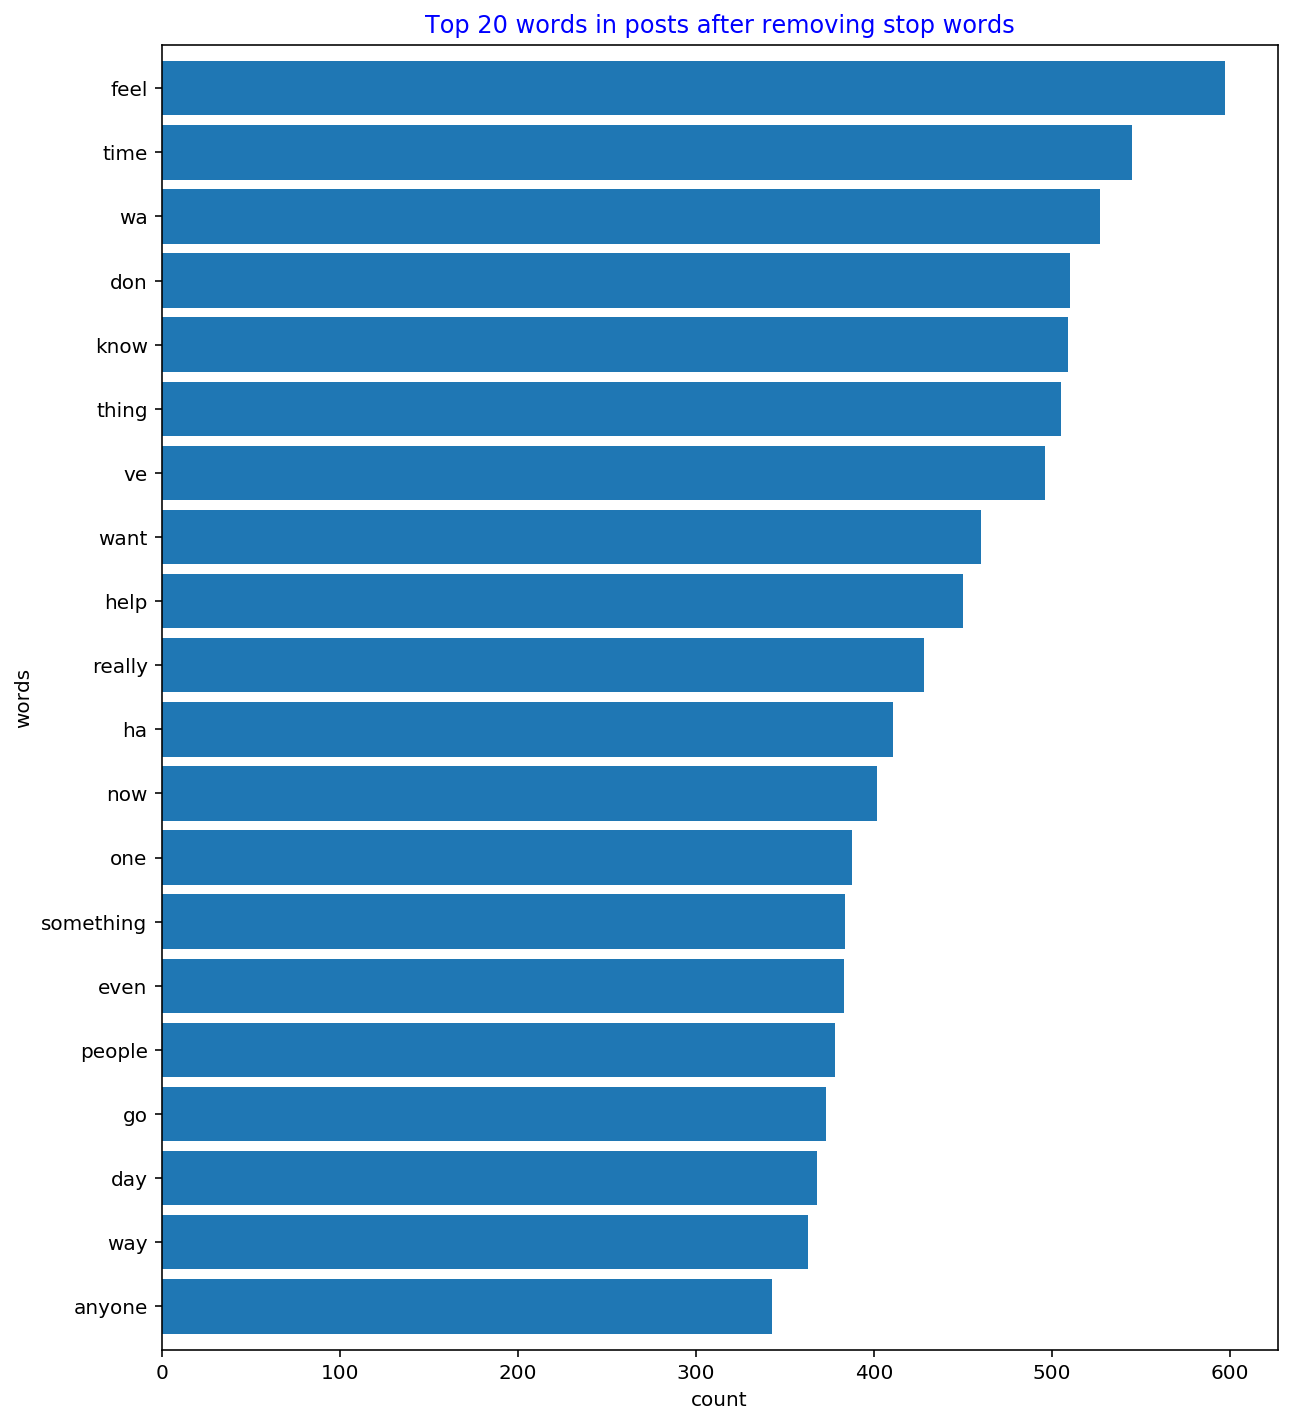

In [29]:
df=pd.DataFrame(clean_train_posts,columns=['posts'])

common_words = get_top_n_words(df['posts'],stop_words,20)
# for word, freq in common_words:
#     print(word, freq)

df2 = pd.DataFrame(common_words, columns = ['posts' , 'count'])
x=df2.groupby('posts').sum()['count'].sort_values(ascending=True)
ax=x.plot(kind='barh',figsize=(10,12),zorder=0,width=0.85)
ax.set_title('Top 20 words in posts after removing stop words',color='blue')
ax.set_ylabel('words')
ax.set_xlabel('count')

### Bag of Words from cleaned posts

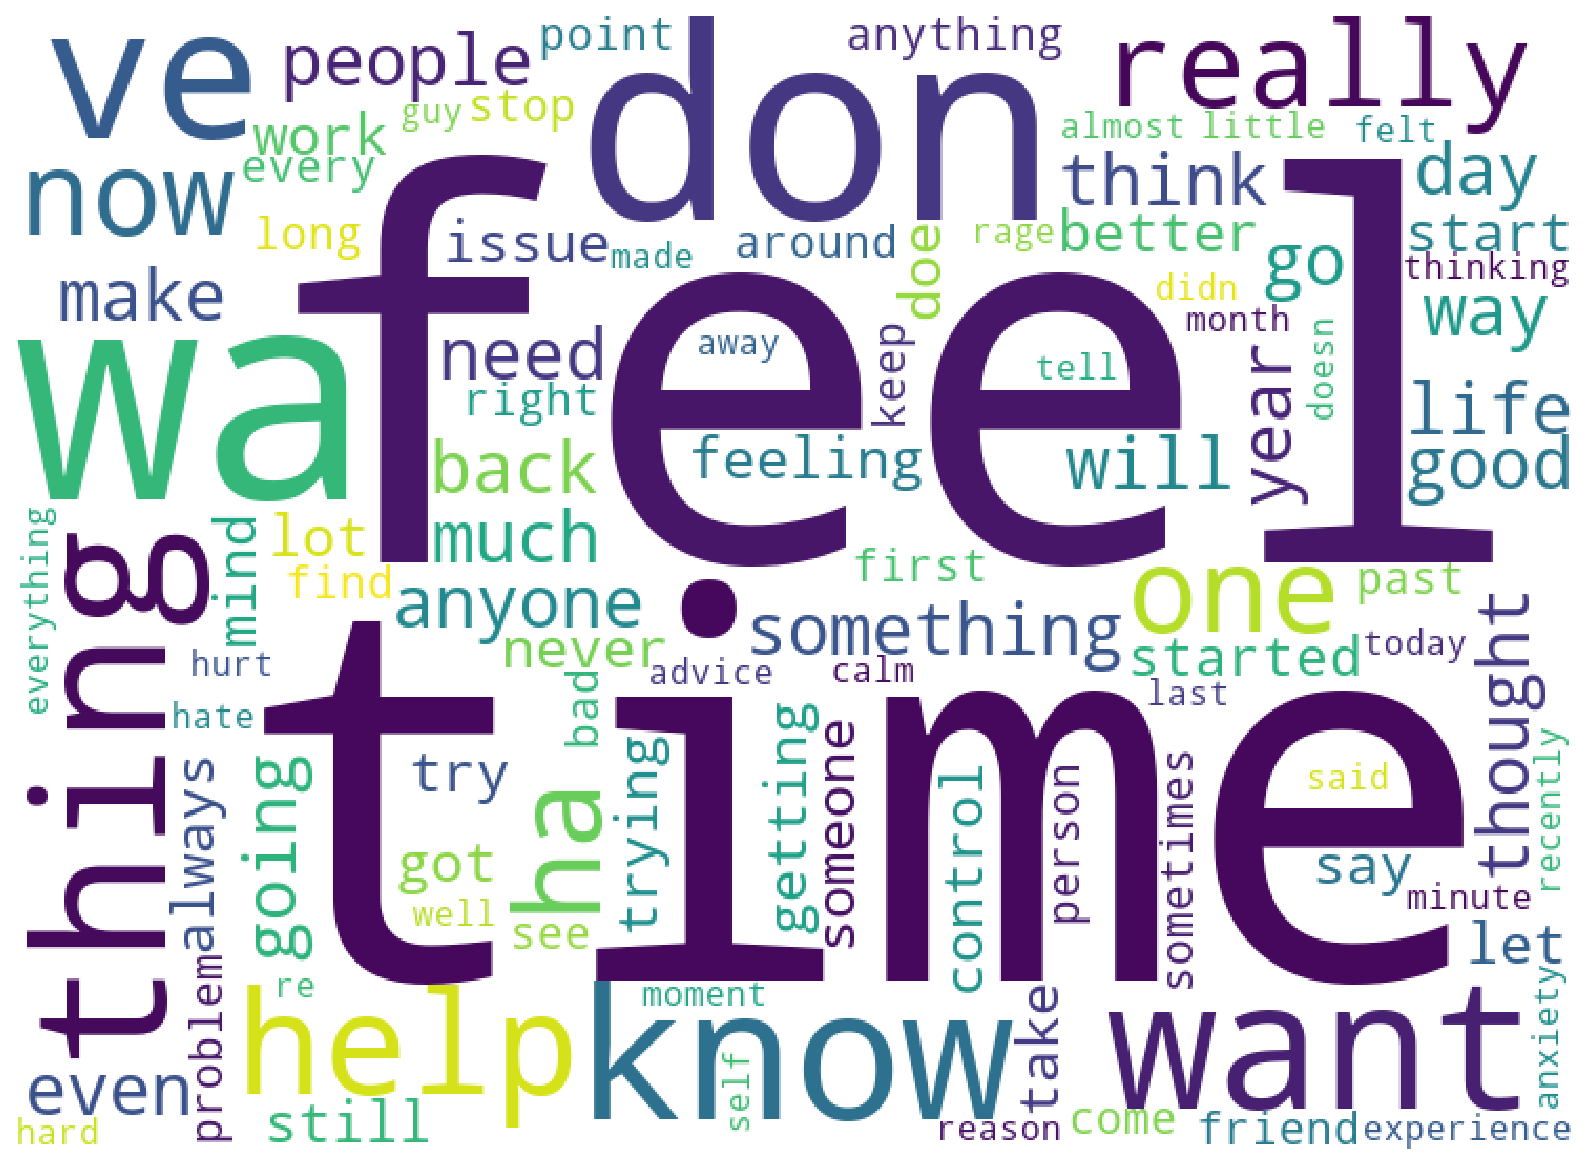

In [30]:
# stop_words_for_bag = list(STOPWORDS)
# for words in stop_words:
#     stop_words_for_bag.append(words)
career_word_cloud = generate_word_cloud(df,100)
plt.figure(figsize = (14, 14)) 
plt.imshow(career_word_cloud) 
plt.axis("off")
plt.savefig('./images/reddit_common_wordcloud.png')

### Check for polarity

In [31]:
df['polarity'] = df['posts'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['posts'].astype(str).apply(len)
df['word_count'] = df['posts'].apply(lambda x: len(str(x).split()))

Randomly select 5 posts to preview the highest sentiment polarity score (1):

In [32]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 1, ['posts']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

best insight meditation timer
envy best rage
best friend
mindfulness best meditation speech thought
suited technique best


Randomly select 5 posts to preview the highest sentiment polarity score (0):

In [33]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 0, ['posts']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

help meditation someone convince anxiety will
stick practice meditation
learn meditation metta
guided meditation
help scream bill t yell


Randomly select 5 posts to preview the most negative sentiment polarity score (-1):

In [34]:
print('5 reviews with the most negative polarity: \n')
cl = df.loc[df.polarity == -1, ['posts']].sample(5).values
for c in cl:
    print(c[0])

5 reviews with the most negative polarity: 

terrible one meditation
hitting insulting self
mom said life aborting cunt t thing uncle pissed called going argument awful break way kicking decided m catch start bitch feel
today awful messed feel
rolling one ball d look opposed ups nasty course month go probs warning another year feel figured


### Sentiment Polarity Distribution

Text(0.5, 0, 'polarity')

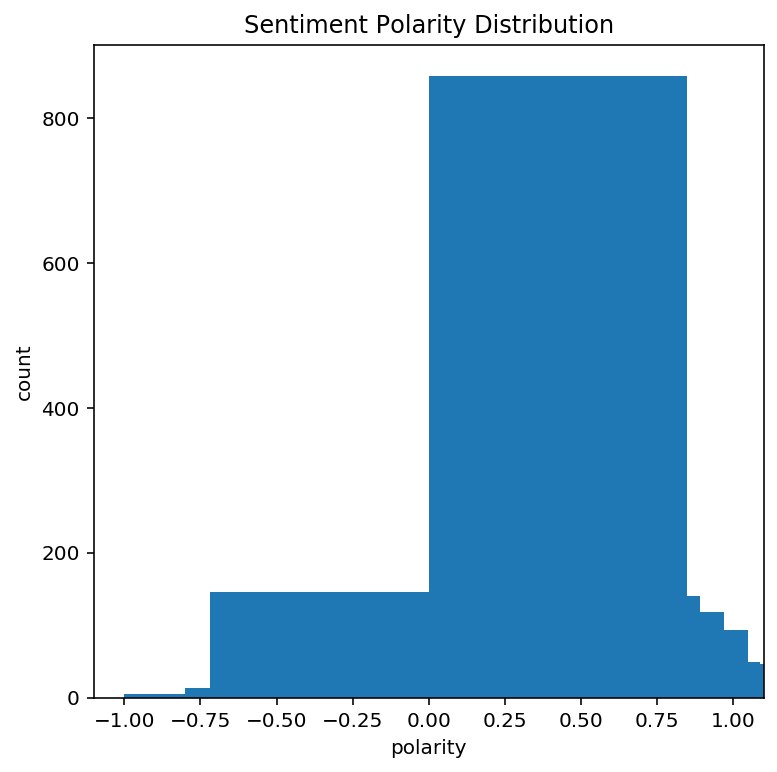

In [35]:
x=df['polarity']
ax=x.plot(kind='hist',bins=50,figsize=(6,6),zorder=0,width=0.85)
ax.set_title('Sentiment Polarity Distribution')
ax.set_ylabel('count')
ax.set_xlabel('polarity')

- From above plot it can be seen that majority of the sentiment polarity scores are greater than zero, means most of them are pretty positive.

# Modeling section

## Logistic Regression

### - Lasso Logistic Regression Model

In [36]:
pred_prob_df = common_fittingmodel(train_data_features,y_train,
                                   test_data_features,y_test,X_TEST_data_features,'Lasso')

Best params = {'lr__C': 2.5, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__random_state': 42, 'lr__solver': 'liblinear', 'lr__warm_start': True}
training score 0.95995670995671: 
test score 0.8344155844155844: 
--------
Confusion Matrix
[[391  57]
 [ 96 380]]
True Negative: 391
False Positive: 57
False Negative: 96
True Positive: 380
Sensitivity: 0.7983
Specificity: 0.8728
--------
COMPARISON BETWEEN PREDICTED AND ACTUAL TARGET VALUES ON THE SLICED DATASET FROM ORIGINAL TESTSET OF POSTS
No. of unmatched predictions wrt actual values: 18
-----------
Row index where Predicted Target Value is not same as Actual Target Value
[0, 4, 13, 16, 18, 22, 26, 28, 42, 50, 53, 55, 59, 61, 66, 67, 79, 92]
--------
Confusion Matrix for predictions on sliced Test data Set
[[38  7]
 [11 44]]
True Negative: 38
False Positive: 7
False Negative: 11
True Positive: 44
Sensitivity: 0.8
Specificity: 0.8444
--------
Accuracy of Model on validation data set: 0.83
Accuracy of Model on sliced Test Data

### Explaining the Logistic regression - Lasso Regression Model from above cells

I defined a function to: 
- GridSearch the best hyperparameters for two Logistic Regresssion Models
- Initialize model using best params
- Fit the Lasso model
- Print the train and test scores for the models. Training score is 0.967 while test score is 0.84. This clearly shows that the model is overfitted
- Make predictions on Validation set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Validation Set, no. of False Positive(31) is lower than no. of False Negative(96)
    - Misclassification of no. of posts 147 from set of 924 test posts is still higher
- Make predictions on Final Test Set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Final Test Set, no. of False Positive(7) is lower than no. of False Negative(12)
    - Misclassification of no. of posts 19 from set of 100 test posts is still higher
- Accuracy of model on train/test set is 84% while the accuracy on final test set is 81%. This means that we need to train the model with more posts to best predict the final posts

#### Plot ROC Curve on probability of final test set 

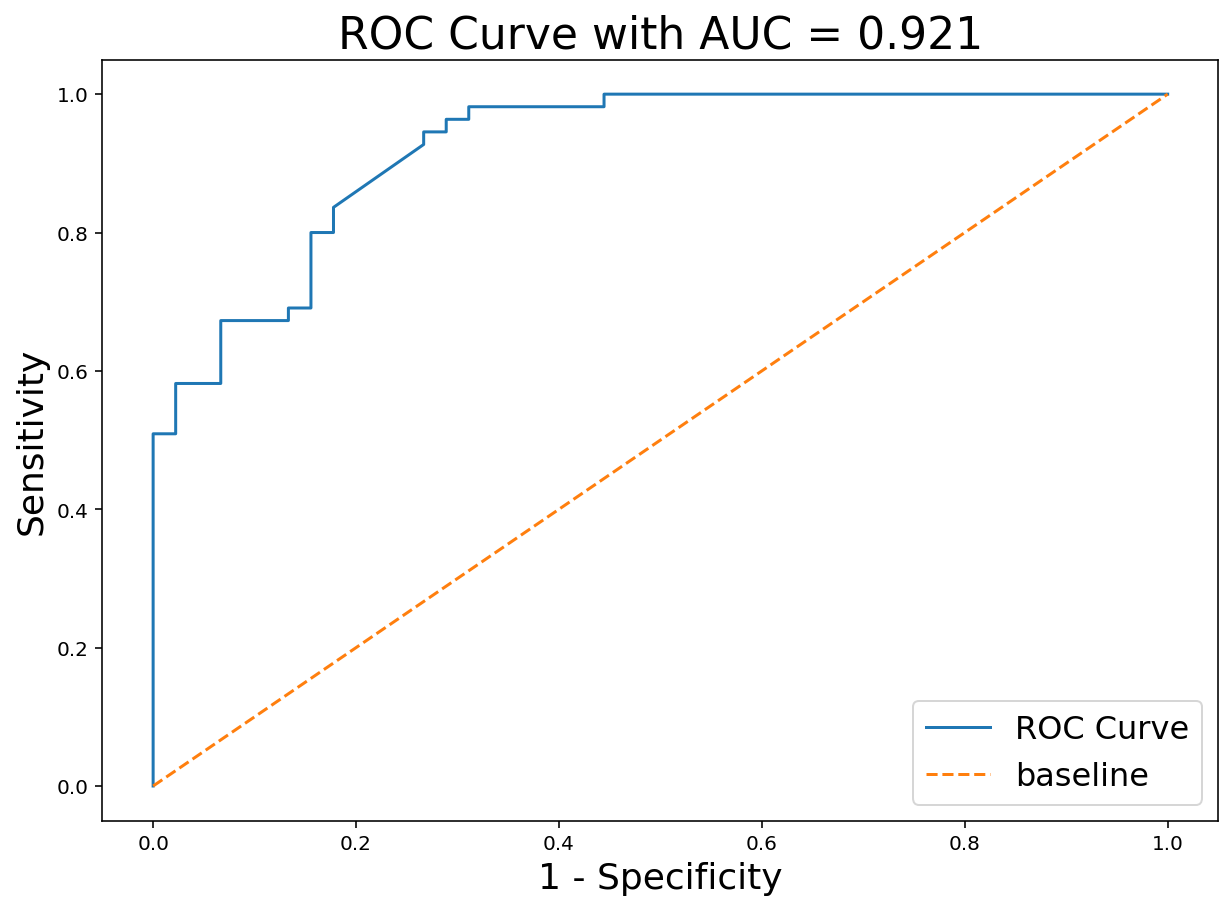

In [37]:
plot_roc_curve(pred_prob_df)

### Interpretation ROC AUC
Above Receiver Operating Characteristic curve visualizes the overlap between positive class and negative class by moving classification threshold from 0 to 1.
- ROC AUC is of 0.927, this means positive and negative populations are very fairly separated and  model can still get better.
- The model needs to be trained more to bring The ROC AUC closer to 1. (1 is the maximum score.)

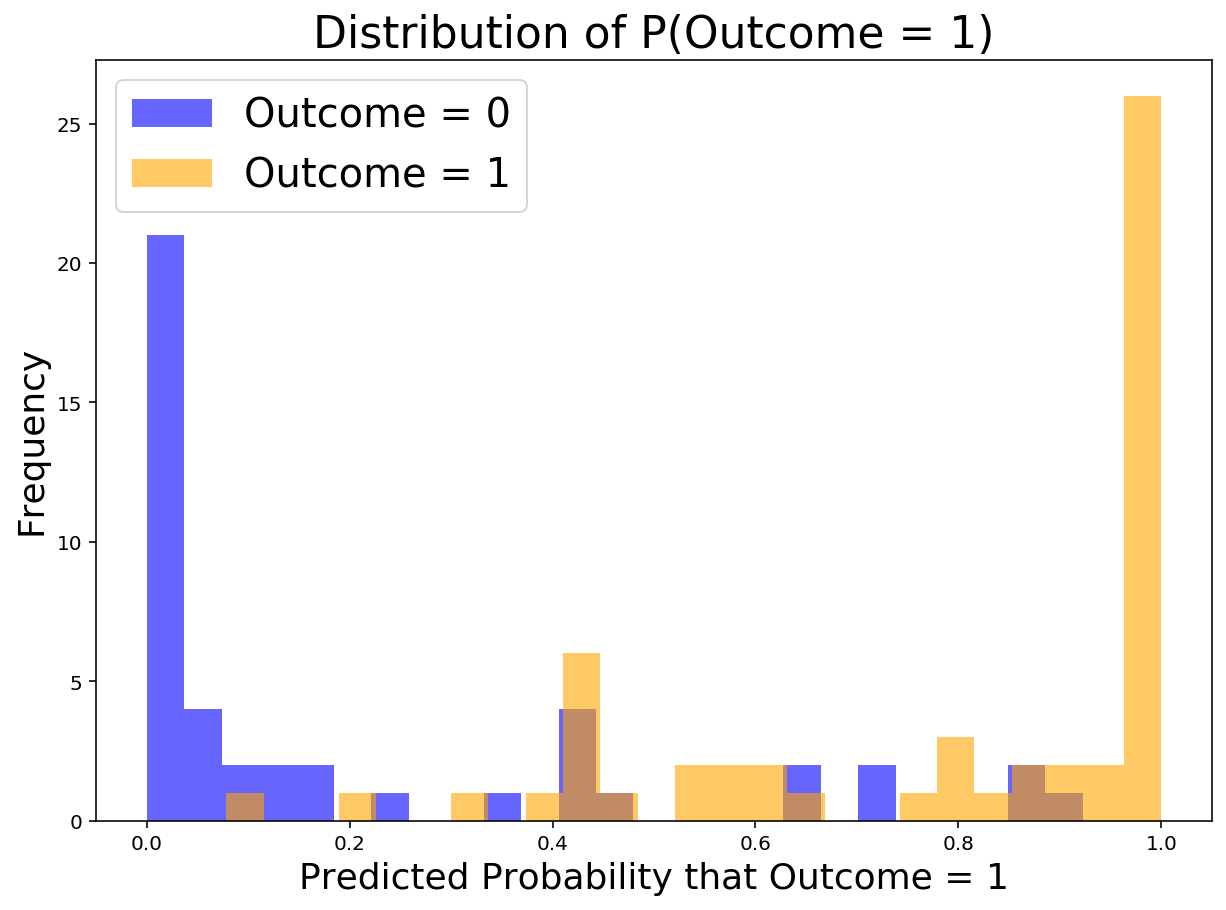

In [38]:
plot_pred_prob(pred_prob_df)

### Interpretation of Distribution of P(outcome) on Final Test Set
- There is some overlap between outcome thus resulting in misclassification
- The number of overlaps have already been printed in above sections

### - Ridge Logistic Regression Model

In [39]:
#pred_prob_df = l_Regression('l2')
pred_prob_df = common_fittingmodel(train_data_features,y_train,test_data_features,
                                   y_test,X_TEST_data_features,'Ridge')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best params = {'lr__C': 1.5, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'lr__random_state': 42, 'lr__solver': 'liblinear', 'lr__warm_start': True}
training score 0.9603174603174603: 
test score 0.8560606060606061: 
--------
Confusion Matrix
[[394  54]
 [ 79 397]]
True Negative: 394
False Positive: 54
False Negative: 79
True Positive: 397
Sensitivity: 0.834
Specificity: 0.8795
--------
COMPARISON BETWEEN PREDICTED AND ACTUAL TARGET VALUES ON THE SLICED DATASET FROM ORIGINAL TESTSET OF POSTS
No. of unmatched predictions wrt actual values: 17
-----------
Row index where Predicted Target Value is not same as Actual Target Value
[0, 13, 18, 21, 22, 26, 40, 45, 46, 50, 55, 59, 61, 66, 67, 79, 92]
--------
Confusion Matrix for predictions on sliced Test data Set
[[39  6]
 [11 44]]
True Negative: 39
False Positive: 6
False Negative: 11
True Positive: 44
Sensitivity: 0.8
Specificity: 0.8667
--------
Accuracy of Model on validation data set: 0.86
Accuracy of Model on sliced Test Data S

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   22.7s finished


### Explaining the Logistic regression - Ridge Regression Model from above cells

I used the function defined before to: 
- GridSearch the best hyperparameters for two Logistic Regresssion Models
- Initiate the model with best parameters
- Fit the Ridge model
- Print the train and test scores for the models. Training score is 0.959 while test score is 0.864. This clearly show that the model is overfitted
- Make predictions on Validation set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Validation Set, no. of False Positive(47) is lower than no. of False Negative(78)
    - Misclassification of no. of posts 125 is high from set of 924 test posts
- Print out the best parameters
- Make predictions on Final Test Set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Final Test Set, no. of False Positive(6) is lower than no. of False Negative(10)
    - Misclassification of no. of posts 16 is still there from set of 100 posts
- Accuracy of model on validation set is 86% while the accuracy on final test set is 84%

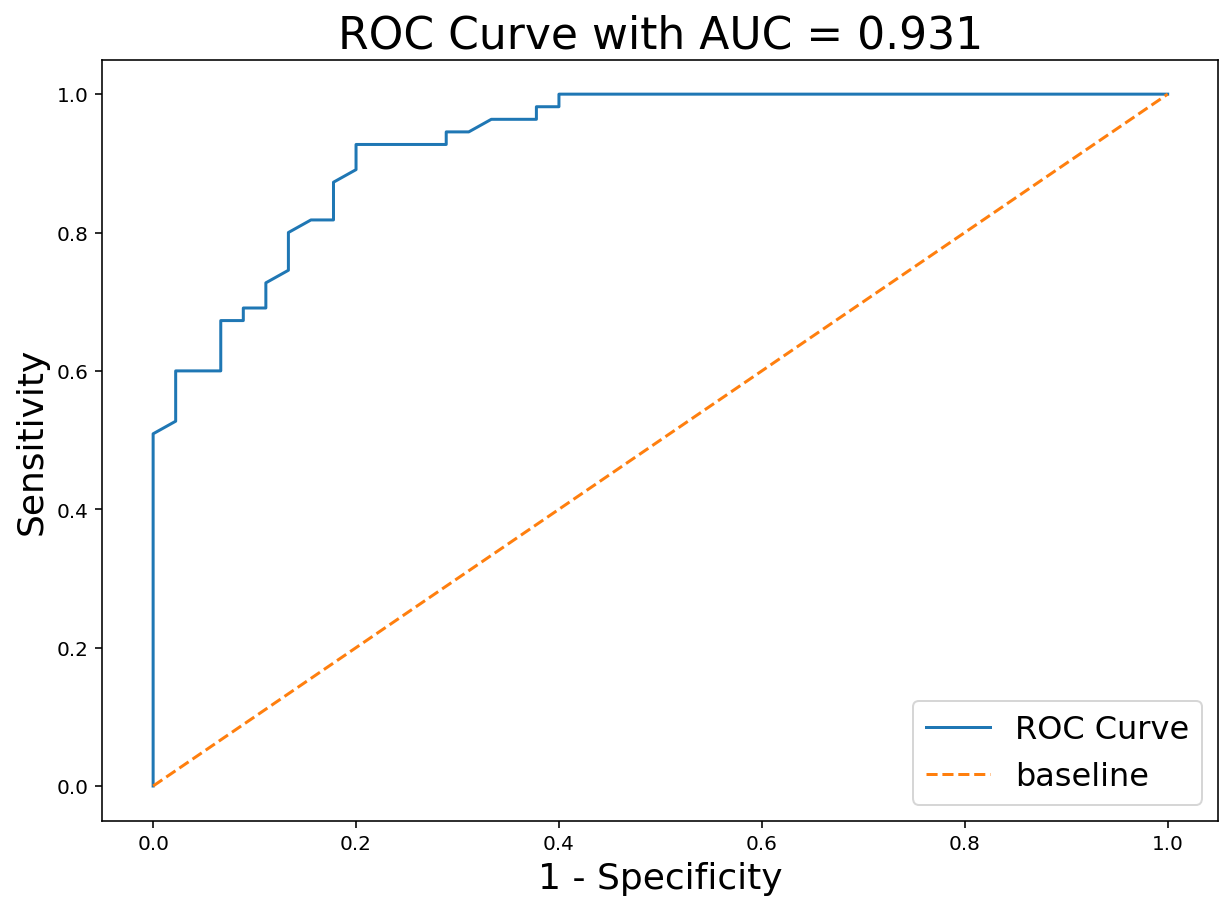

In [40]:
plot_roc_curve(pred_prob_df)

### Interpretation ROC AUC
Above Receiver Operating Characteristic curve visualizes the overlap between positive class and negative class by moving classification threshold from 0 to 1.
- ROC AUC is of 0.934, this means positive and negative populations are very well separated and  model is as good as it can get.
- The ROC AUC is closer to 1 therefore the model is better. (1 is the maximum score.)

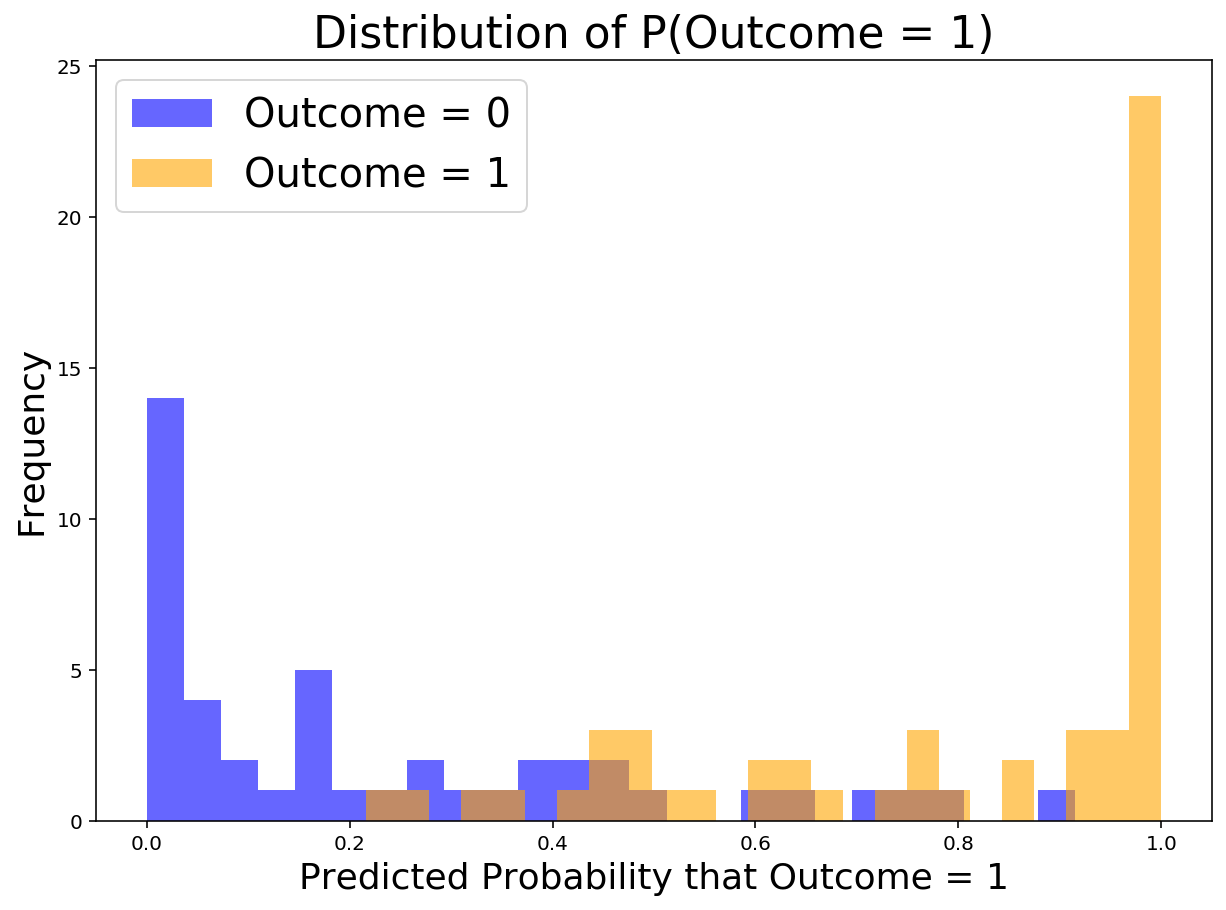

In [41]:
plot_pred_prob(pred_prob_df)

### Interpretation of Distribution of P(outcome) on Final Test Set
- There is lsomeot of overlap between outcome thus resulting in misclassification
- The number of overlaps have already been printed in above sections

## Comparison between Lasso and Ridge Logistic Regression model
 - Ridge performed better with accuracy score on final test of 91% in cormparison to Lasso with accuracuy score of 88%
 - AUC of Ridge model is better with value 0.982 while taht of Lasso is 0.976. This means area under the curve is more for Ridge model thus the positive and neagative populations are well separated

## NaiveBayes Model

In [42]:
pred_prob_df = common_fittingmodel(train_data_features,y_train,test_data_features,
                                   y_test,X_TEST_data_features,'MultinomialNB')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best params when fit_prior is False = {'alpha': 0.5, 'fit_prior': False}
training score 0.9036796536796536: 
test score 0.8841991341991342: 
--------
Confusion Matrix
[[402  46]
 [ 61 415]]
True Negative: 402
False Positive: 46
False Negative: 61
True Positive: 415
Sensitivity: 0.8718
Specificity: 0.8973
--------
COMPARISON BETWEEN PREDICTED AND ACTUAL TARGET VALUES ON THE SLICED DATASET FROM ORIGINAL TESTSET OF POSTS
No. of unmatched predictions wrt actual values: 17
-----------
Row index where Predicted Target Value is not same as Actual Target Value
[0, 7, 18, 20, 21, 23, 39, 40, 45, 50, 55, 59, 60, 61, 67, 78, 81]
--------
Confusion Matrix for predictions on sliced Test data Set
[[37  8]
 [ 9 46]]
True Negative: 37
False Positive: 8
False Negative: 9
True Positive: 46
Sensitivity: 0.8364
Specificity: 0.8222
--------
Accuracy of Model on validation data set: 0.88
Accuracy of Model on sliced Test Data Set: 0.83


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished


### Explaining the Multi Nomial Naive Bayes Model from above cells
I used the function defined before to: 
- GridSearch the best hyperparameters for MultinomialNaiveBayes Model
- Initiate the MultiNomialNB Classifier using best params derived from grid search
- Fit the MultiNomialNB model
- Print the train and test scores for the models. Training score is 0.91 while test score is 0.88. This means that the model is slightly overfitted
- Make predictions on Validatiuon set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Validation Set, no. of False Positive(55) is more than no. of False Negative(52)
    - Misclassificatio  of no. of posts 107 is high from set of 924 test posts
- Print out the best parameters
- Make predictions on Final Test Set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Final Test Set, no. of False Positive(9) is higher than no. of False Negative(7)
- Accuracy of model on validation set is 88% and the accuracy of model on final test set is 84%
- Since the accuracy score is still not above 90 so it can be said that we need more posts to handle misclassification to train the model and also need to add more variance to avoid overfitting

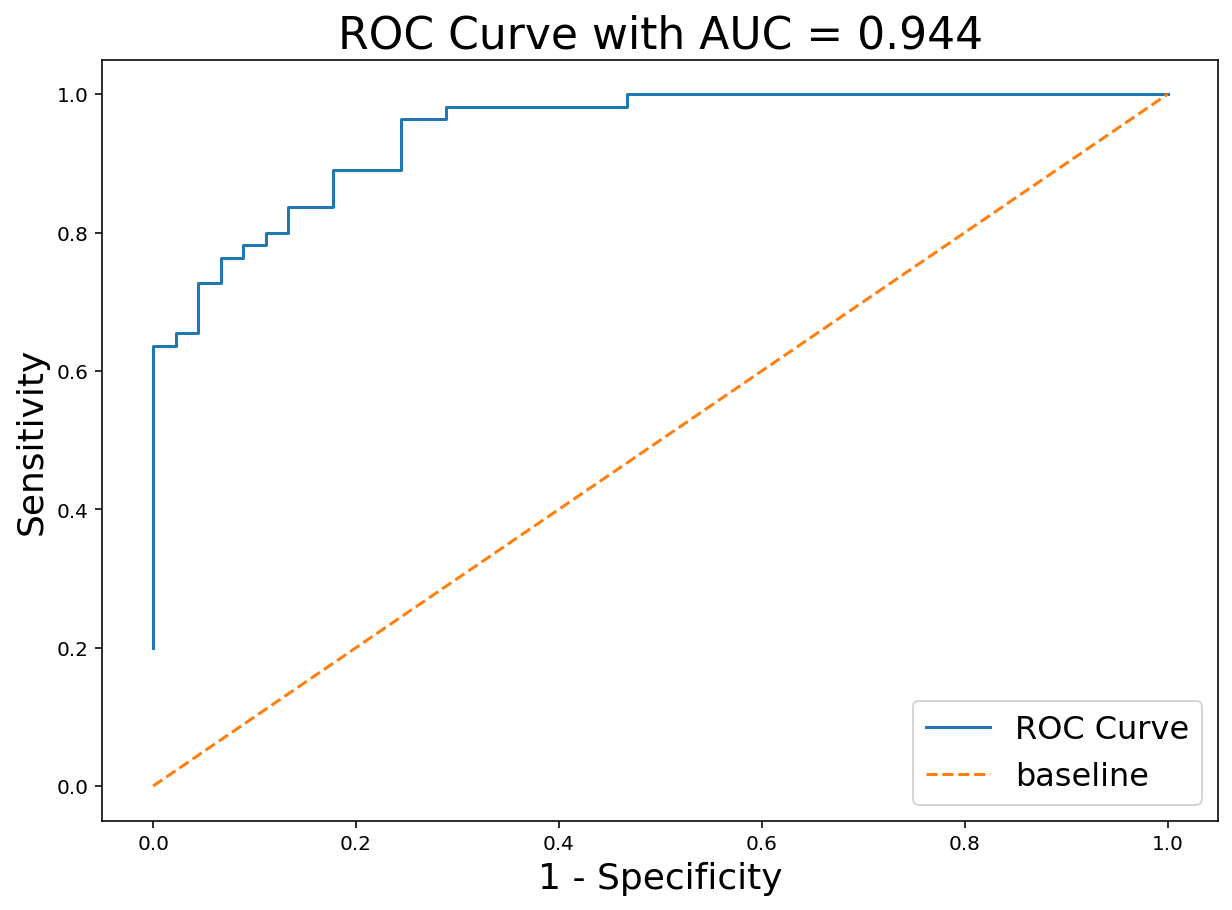

In [43]:
plot_roc_curve(pred_prob_df)

### Interpretation ROC AUC
Above Receiver Operating Characteristic curve visualizes the overlap between positive class and negative class by moving classification threshold from 0 to 1.
- ROC AUC is of 0.948, this means positive and negative populations are very well separated and  model is as good as it can get.
- Though there are few misclassifications on final test set however ROC AUC is closer to 1 therefore the model is better for prediction. (1 is the maximum score.)

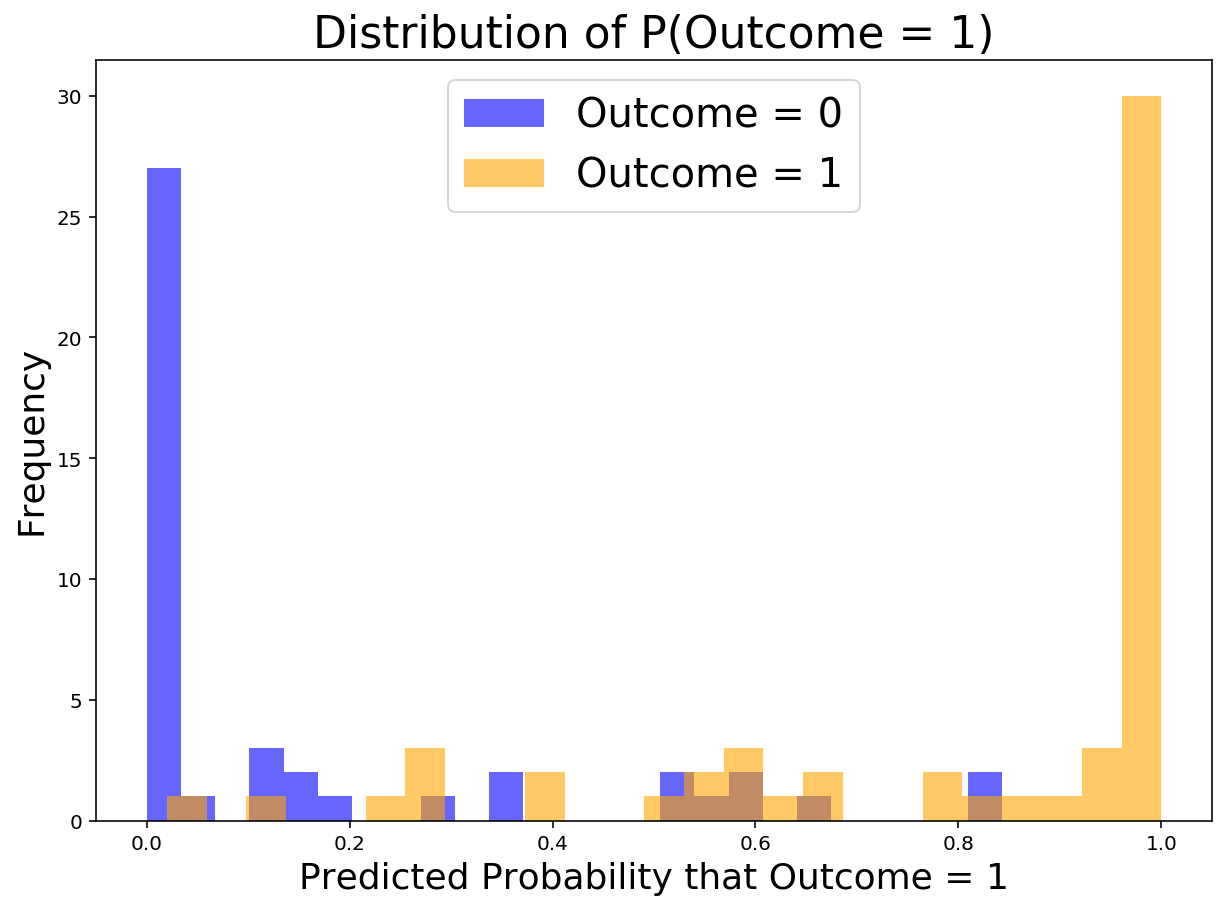

In [44]:
plot_pred_prob(pred_prob_df)

### Interpretation of Distribution of P(outcome) on Final Test Set
- There is few overlap between outcome thus resulting in misclassification
- The number of overlaps have already been printed in above sections

## Random Forest Model

### Random Forest with hyperparameter criterion as gini

In [45]:
pred_prob_df = common_fittingmodel(train_data_features,y_train,test_data_features,
                                   y_test,X_TEST_data_features,'RandomForest_gini')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.2min finished


Best params = {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 30}
training score 0.9040404040404041: 
test score 0.8106060606060606: 
--------
Confusion Matrix
[[389  59]
 [116 360]]
True Negative: 389
False Positive: 59
False Negative: 116
True Positive: 360
Sensitivity: 0.7563
Specificity: 0.8683
--------
COMPARISON BETWEEN PREDICTED AND ACTUAL TARGET VALUES ON THE SLICED DATASET FROM ORIGINAL TESTSET OF POSTS
No. of unmatched predictions wrt actual values: 23
-----------
Row index where Predicted Target Value is not same as Actual Target Value
[0, 4, 7, 11, 13, 18, 21, 22, 26, 28, 39, 40, 47, 50, 53, 55, 61, 66, 70, 79, 85, 89, 92]
--------
Confusion Matrix for predictions on sliced Test data Set
[[39  6]
 [17 38]]
True Negative: 39
False Positive: 6
False Negative: 17
True Positive: 38
Sensitivity: 0.6909
Specificity: 0.8667
--------
Accuracy of Model on validation data set: 0.81
Accuracy of Model on sliced Test Data Set: 0.77


### Explaining the Random Forest Model with crietrion as gini from above cells
I used the function defined before to: 
- GridSearch the best hyperparameters for criterion as gini for RandomForest Model
- Fit the RandomForest model
- Print the train and test scores for the models. Training score is 0.898 while test score is 0.829. This means that the model is fitted well. However t
- Make predictions on validation test set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For validation Test Set, no. of False Positive(56) is lower than no. of False Negative(102)
    - However the misclassification of no. of 158 posts is high given from set of 924 test posts
- Print out the best parameters
- Make predictions on Final Test Set and print them in a confusion matrix. From the Confusion matrix it can be seen that
    - For Final Test Set, no. of False Positive(6) is lower than no. of False Negative(14)
    - However the misclassification of no. of 20 posts is high given from set of 100 test posts
- Accuracy of model on validation set is 84% and the accuracy on final test set is 80%
- With 80% accuracy score on final test posts it can be said that its not the best model to predict. We need to add more training set to train the model for best fit

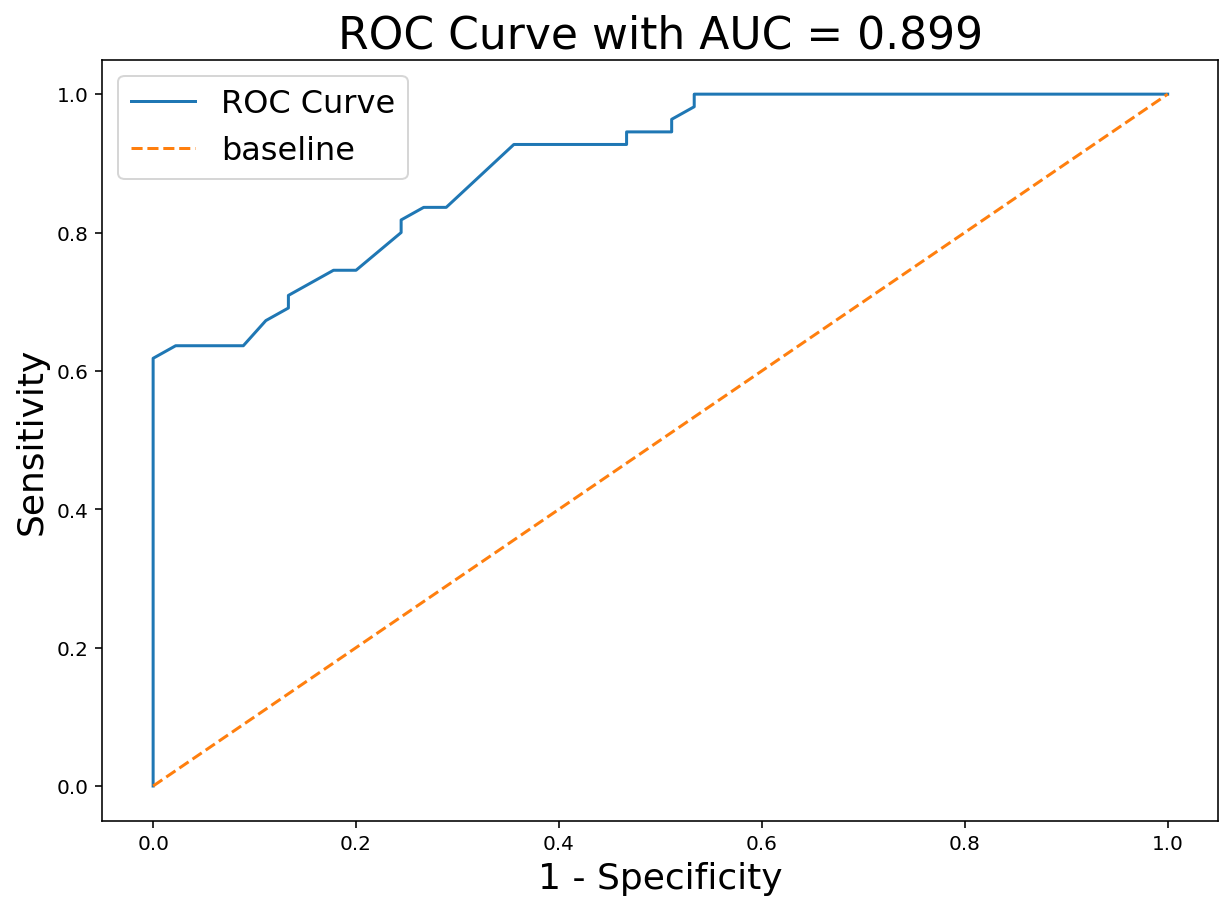

In [46]:
plot_roc_curve(pred_prob_df)

### Interpretation ROC AUC
Above Receiver Operating Characteristic curve visualizes the overlap between positive class and negative class by moving classification threshold from 0 to 1.
- ROC AUC is of 0.894, this means positive and negative populations are fairly separated and  model can still get better.
- The ROC AUC is about 0.8. We need to train the model with more posts to bring ROC AUC value closer 1 so that model can do best fit

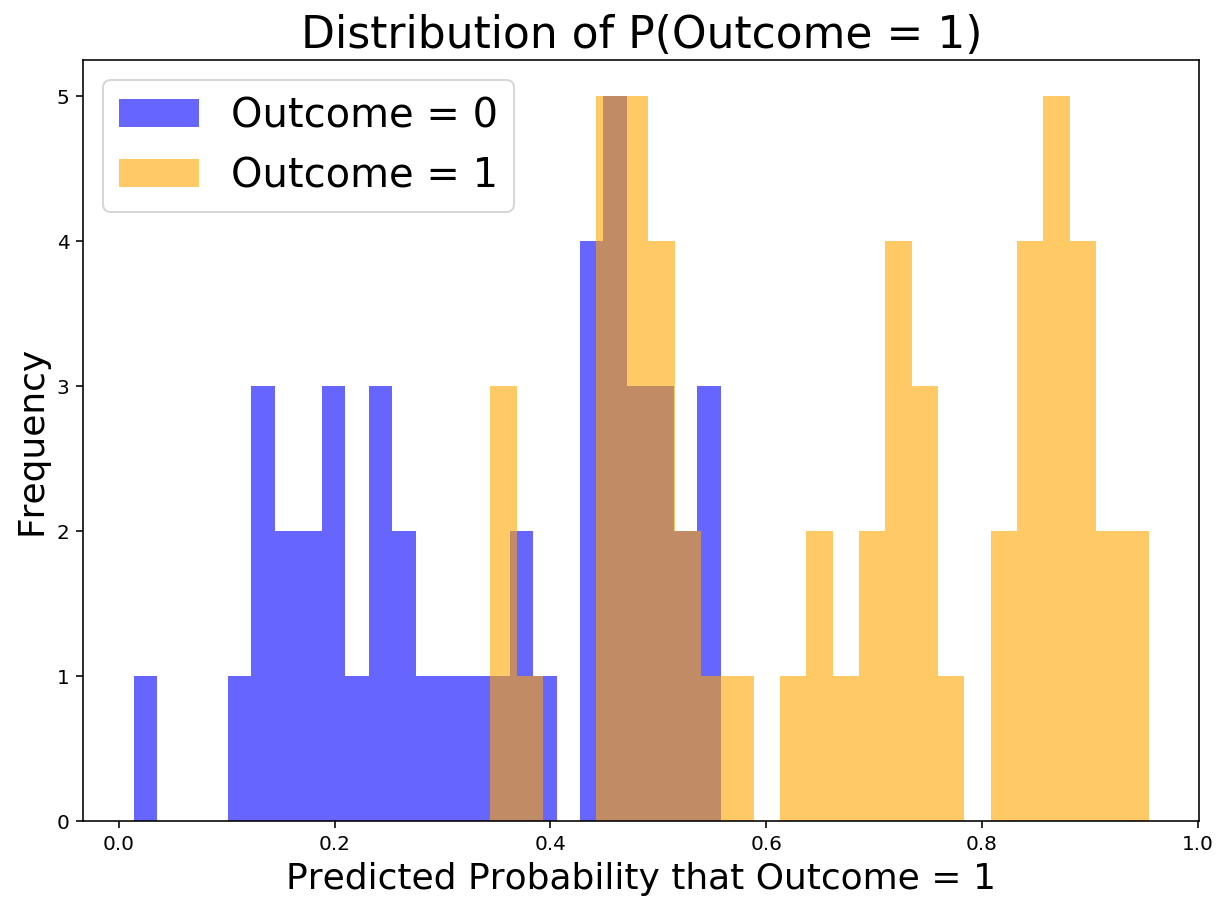

In [47]:
plot_pred_prob(pred_prob_df)

### Interpretation of Distribution of P(outcome) on Final Test Set
- There is lot of overlap between outcome thus resulting in misclassification
- The number of overlaps have already been printed in above sections

In [48]:
model_matrix_df.dropna(inplace=True)

In [49]:
model_matrix_df.drop(columns=['model_type'],inplace=True)

In [50]:
model_matrix_df

,train_score,test_score,val_accrcy,final_test_accrcy,final_test_specificity,final_test_sensitivity,total_test_posts,fale_postive,fale_negative
Lasso,0.959957,0.834416,0.834416,0.82,0.844444,0.8,100,7,11
Ridge,0.960317,0.856061,0.856061,0.83,0.866667,0.8,100,6,11
MultiNomialNB,0.90368,0.884199,0.884199,0.83,0.822222,0.836364,100,8,9
RandomForest,0.90404,0.810606,0.810606,0.77,0.866667,0.690909,100,6,17


## Comparison and Recommendation
- I have fit 4 models on reddit posts with two categories - Anger and Meditaion labeled as 1 and 0
    - Lasso Logistic Regression model
    - Ridge Logistic Regression model
    - Multinomial Naive Bayes model
    - Random Forest model
- From above metrics it can be seen that MultiNomialNB and Ridge Logistic Regression have good validation and accuracy score with final Test accuracy of 0.84
- Need more posts to train the model so that model can give good test accuracy and can be used for best predictions
- From above metrics MultiNomialNB can be considered as best fit

In [51]:
# ## Extra
# #prob for label 0 class
# pos_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
# #prob for label 1 class
# neg_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

# #getting the top features 
# p_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)
# mh_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)
# Collapse

In [52]:
final_predictions_df
#[[0, 7, 20, 21, 23, 39, 40, 50, 55, 59, 60, 61, 67, 78, 79, 81]]
#[0, 13, 18, 22, 26, 40, 45, 46, 50, 55, 59, 61, 66, 67, 79, 92]

""
